# Zadanie

Otrzymałeś zadanie pogrupowania klientów dużego sklepu online.
Użyj metody RFM (recency, frequency, monetary value) oraz metody kwantyli (K-means) aby przekazać
pracownikom działu marketingu kilka wersji segmentacji behawioralnej.
W końcowych rozważaniach scharakteryzuj powstałe grupy i wybierz model twoim zdaniem najlepszy.

## Metoda RFM

RFM to narzędzie analizy marketingowej służące do identyfikacji najlepszych klientów firmy lub organizacji za pomocą określonych miar. 

Model RFM opiera się na trzech czynnikach:

* recency: jak niedawno klient dokonał zakupu
* frequency: jak często klient dokonuje zakupu
* monetary value: ile pieniędzy klient wydaje na zakupy

Analiza RFM pomaga firmom rozsądnie przewidzieć, którzy klienci są bardziej skłonni do ponownych zakupów w przyszłości, ile przychodów pochodzi od nowych (w porównaniu z powracającymi klientami) i jak zmienić okazjonalnych kupujących w stałych klientów.

## Zbiór danych


* <a href="https://archive.ics.uci.edu/ml/datasets/Online+Retail+II" target="_blank">Link do zbioru danych</a> 
* Autor - Dr. Daqing Chen
* Data publikacji - 2019-09-21
* Liczba obserwacji początkowa - 1067371
* Liczba atrybutów - 8
* Brakujące wartości - TAK

## Zbiór danych - atrybuty

1. **Invoice** - numer faktury, 6-cyfrowy numer jednoznacznie przypisany do każdej transakcji. Jeśli kod rozpoczyna się od litery 'c', oznacza to fakturę anulowaną.
2. **StockCode** - kod produktu, 5-cyfrowy numer jednoznacznie przypisany do każdego odrębnego produktu
3. **Description** - opis
4. **Quantity** - ilość każdego produktu na transakcję
5. **InvoiceDate** - data i godzina wystawienia faktury
6. **Price** - cena jednostkowa
7. **Customer ID** - numer klienta
8. **Country** - nazwa kraju, z którego pochodzi klient

# Realizacja zadania

### Biblioteki

Na samym początku wczytuję potrzebne do realizacji zadania biblioteki

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Pandas options

Za pomocą 'pandas' ustawiam formatowanie zmiennych ciągłych z precyzją do trzech miejsc po przecinku oraz ustawiam wyświetlanie wszystkich kolumn.

In [79]:
pd.set_option('float_format', '{:.3f}'.format)
pd.set_option("display.max_columns", 999)

### Dataset

Przy pomocy 'pandas' wczytuję plik danych oraz ustawiam nazwy kolumn. Jest to przydatne przy atrybucie 'Customer ID' aby uniknąć spacji w nazwie.

In [80]:
df = pd.read_csv('online_retail_II.csv')
df.columns = ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'CustomerID', 'Country']

C:\Users\curio\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Typy zmiennych

Jak można zauważyć przy konwersji pliku danych wystąpiły pewne komplikacje. 
Sprawdzam jakie typy mają atrybuty.

In [81]:
print(df.dtypes)

Invoice        object
StockCode      object
Description    object
Quantity       object
InvoiceDate    object
Price          object
CustomerID     object
Country        object
dtype: object


### Brakujące wartości
Typy atrybutów zostały nadpisane wszędzie jako 'object'.
Naprawą tego błędu zajmę się za chwilę.
W opisie bazy danych widnieje informacja o brakujących wartościach.
Sprawdzam ile ich jest i jakie to zmienne.

In [82]:
summary = pd.DataFrame(df.dtypes, columns=['Dtype'])
summary['Nulls'] = pd.DataFrame(df.isnull().any())
summary['Sum'] = pd.DataFrame(df.isnull().sum())
summary.Dtype = summary.Dtype.astype(str)
print(summary)

              Dtype  Nulls     Sum
Invoice      object  False       0
StockCode    object  False       0
Description  object   True    4382
Quantity     object  False       0
InvoiceDate  object  False       0
Price        object  False       0
CustomerID   object   True  243007
Country      object  False       0


### Ilość obserwacji

Przed eliminacją obserwacji z brakującymi wartościami sprawdzam ile jest obserwacji na ten moment.

In [83]:
print('Pozostało ' + str(df.shape[0]) + ' obserwacji.')

Pozostało 1067372 obserwacji.


### Braki danych jako procenty

Wyświetlam dla lepszego zobrazowania sytuacji ile obserwacji zawiera błędy względem wszystkich obserwacji.

In [84]:
print(str(round(df.isnull().any(axis=1).sum() / df.shape[0] * 100, 2)) + '% obserwacji zawiera braki w danych.')

22.77% obserwacji zawiera braki w danych.


### Pierwsze wnioski

* Istnieją klienci bez identyfikatora
* Dwa atrybuty zawierają braki w wartościach (CustomerID oraz Description)
* Aby segmentacja była rzetelna jestem zmuszony usunąć wiersze obserwacji zawierające błedy

### Usuwanie wierszy - CustomerID

Usuwam wiersze obserwacji, gdzie CustomerID jest null (klienci bez identyfikatora).
Sprawdzam ile wierszy obserwacji pozostało po tej operacji.

In [85]:
df = df[~df.CustomerID.isnull()]
print('Pozostało ' + str(df.shape[0]) + ' obserwacji.')

Pozostało 824365 obserwacji.


### Usuwanie wierszy - anulowane faktury

Usuwam wiersze, gdzie w numerze faktury występują inne znaki niż cyfry. Wprowadzenie do modelu faktur, które zostały anulowane z nieznanych nam przyczyn mogłoby wprowadzić w błąd. Sprawdzam ponadto ile wierszy obserwacji pozostało po tej operacji.

In [86]:
df = df[df.Invoice.astype('str').str.isdigit()]
print('Pozostało ' + str(df.shape[0]) + ' obserwacji.')

Pozostało 805620 obserwacji.


### Braki danych jako procenty

Upewniam się że wszelkie wiersze, zawierające braki zostały usunięte.
Jak widać zostały usunięte wszystkie wiersze gdzie niewystępował opis.
Te wiersze moglibyśmy pominąć, wszak opis nam nie wadzi, jednak wniosek z tego taki, że wiersze z brakującym opisem były podzbiorem zbioru wierszy o niezidentyfikowanym numerze klienta.

In [87]:
print(str(round(df.isnull().any(axis=1).sum() / df.shape[0] * 100, 3)) + '% obserwacji zawiera braki w danych.\n')
summary = pd.DataFrame(df.dtypes, columns=['Dtype'])
summary['Nulls'] = pd.DataFrame(df.isnull().any())
summary['Sum'] = pd.DataFrame(df.isnull().sum())
summary.Dtype = summary.Dtype.astype(str)
print(summary)

0.0% obserwacji zawiera braki w danych.

              Dtype  Nulls  Sum
Invoice      object  False    0
StockCode    object  False    0
Description  object  False    0
Quantity     object  False    0
InvoiceDate  object  False    0
Price        object  False    0
CustomerID   object  False    0
Country      object  False    0


### Usuwanie zbędnych atrybutów

Usuwam kolumny z atrybutami, które nie będą nam potrzebne. Są to kolejno: opis, kod produktu oraz kraj, z którego pochodzi klient.

In [88]:
df.drop(['Description', 'StockCode', 'Country'], axis = 1, inplace = True)

### Zmiana typów

Podczas konwersji pliku ze zbiorem danych nastąpiły pewne komplikacje - typy zmiennych zostały nadpisane jako 'object'. Naprawiam to, zmieniając typy poszczególnych atrybutów. Dla pewności wyświetlam informacje o nich.

In [89]:
df['CustomerID'] = df.CustomerID.astype(int)
df['Invoice'] = df.Invoice.astype(int)
df['Quantity'] = df.Quantity.astype(int)
df['Price'] = df.Price.astype(float)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [90]:
print(df.dtypes)

Invoice                 int32
Quantity                int32
InvoiceDate    datetime64[ns]
Price                 float64
CustomerID              int32
dtype: object


### Stare transakcje

W grupowaniu metodą RFM zazwyczaj przyjmuje się, że brane pod uwagę są jedynie operacje z ostatnich 12 miesięcy. Przyczyna takiego zabiegu jest prosta: starsze operacje mogą niewiele mówić o obecnej sytuacji sprzedającego, kupującego i o samym produkcie. Oczywiście mowa o przypadku ogólnym. Są branże, w których relacja z klientem i produkt ma zdecydowanie dłuższy cykl życia.

Uznajmy, że dział marketingu zażyczył sobie aby brać pod uwagę transakcję sprzed dwóch lat od najnowszej transakcji.

Gdybym rozpatrywał przypadek gdzie liczyłbym od dnia dzisiejszego, tj. 01/04/2021 niemiałbym na czym działać, gdyż dane są dość wiekowe.

Przypisuję datę najnowszej transakcji do zmiennej oraz pozostawiam tylko te transakcje do dwóch lat wstecz.

In [92]:
lastInvoice = df.InvoiceDate.max()
print(lastInvoice)

2011-12-09 12:50:00


In [93]:
df = df[df.InvoiceDate >= lastInvoice - pd.to_timedelta(365*2, "D")]
print('Pozostało ' + str(df.shape[0]) + ' obserwacji.')

Pozostało 790647 obserwacji.


### Monetary value

Aby móc przeprowadzić metodę RFM dodaję zmienną MonetaryValue, która jest iloczynem ilości produktów i ceny jednostkowej.
Dodatkowo wyświetlam informacje o tym atrybucie.

In [99]:
df['MonetaryValue'] = df.Quantity * df.Price
print(df.MonetaryValue.describe())

count   790647.000
mean        22.036
std        225.957
min          0.000
25%          4.950
50%         11.850
75%         19.500
max     168469.600
Name: MonetaryValue, dtype: float64


### Recency

Metoda RFM zakłada także występowanie zmiennej Recency, czyli informacja o tym, jak dawno klient robił zakupy w sklepie.

In [100]:
df['Recency'] = (lastInvoice - df.InvoiceDate)/np.timedelta64(1,'D')

### Frequency

Do tej pory operowałem na poziomie pojedynczego produktu. By wykonać grupowanie RFM muszę przejść do agregacji na poziomie klienta. Dodatkowo zmieniam nazwę zmiennych i wyświetlam dane.

In [106]:
rfm = df.groupby(['CustomerID']).agg({'Recency':'min', 'MonetaryValue':'sum', 'Invoice':'count'})

In [107]:
rfm.rename(columns = {'Invoice':'Frequency'}, inplace = True)
rfm = rfm[['Recency', 'Frequency', 'MonetaryValue']]
print(rfm)

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346       325.117         34      77556.460
12347         1.874        253       5633.320
12348        74.984         51       2019.400
12349        18.124        175       4428.690
12350       309.867         17        334.400
...             ...        ...            ...
18283         3.033        986       2736.650
18284       431.053         28        461.680
18285       660.101         12        427.000
18286       476.037         67       1296.430
18287        42.140        155       4182.990

[5836 rows x 3 columns]


### Transformacja zmiennych

Metoda RFM wymaga zmiennych porządkowych. Zrobię to za pomocą percentyli rozkładu danej zmiennej. Wartości będą równe 0, 1, 2 lub 3. Wyższa etykieta oznacza lepszą sytuację z punkty widzenia sprzedającego. Wyświetlam dane i tak pierwszego klienta można scharakteryzować jako osobę, która dużo wydała w sklepie, rzadko robi zakupy a zakupy robiła w niedalekiej przeszłości.

In [110]:
r = pd.qcut(rfm.Recency, 4, labels = list(range(0,4)))
f = pd.qcut(rfm.Frequency, 4, labels = list(range(0,4)))
m = pd.qcut(rfm.MonetaryValue, 4, labels = list(range(0,4)))
rfm_cutted = pd.DataFrame({'Recency' : r, 'Frequency' : f, 'MonetaryValue' : m})
rfm_raw = rfm_cutted.values
print(rfm_raw)

[[2 1 3]
 [0 3 3]
 [1 1 2]
 ...
 [3 0 1]
 [3 2 2]
 [1 3 3]]


### Wybór odpowiedniej liczby grup

Inercja to metryka używana do szacowania, jak blisko klastra znajdują się punkty danych. Oblicza się ją jako sumę kwadratów odległości dla każdego punktu względem najbliższego środka ciężkości, tj. Przypisanego środka gromady. Interwencja inercji polega na tym, że klastry o mniejszej inercji są lepsze, ponieważ zaznaczają blisko powiązane punkty tworzące klaster.

In [120]:
res = []
for n in range(2, 20):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(rfm_raw)
    res.append([n, kmeans.inertia_])
res = pd.DataFrame(res, columns = ['liczbaGrup', 'inercja'])
print(res)

    liczbaGrup   inercja
0            2 10129.974
1            3  7851.859
2            4  5560.941
3            5  4907.988
4            6  3979.155
5            7  3703.274
6            8  3318.774
7            9  3127.787
8           10  2794.766
9           11  2687.992
10          12  2433.612
11          13  2181.097
12          14  2099.030
13          15  1958.320
14          16  1805.164
15          17  1666.586
16          18  1587.986
17          19  1402.610


### Wykres do wyboru ilości grup

Jak widać im więcej grup tym inercja mniejsza, jednak z logicznego punktu widzenia nie ma sensu w aspekcie marketingowym rozbijania klientów na kilkanaście czy nawet kilkadziesiąt grup. Ładne 'spadki' inercji jest dla czterech, sześciu oraz ośmiu grup. Właśnie dla tych wartości przeprowadzę analizę.

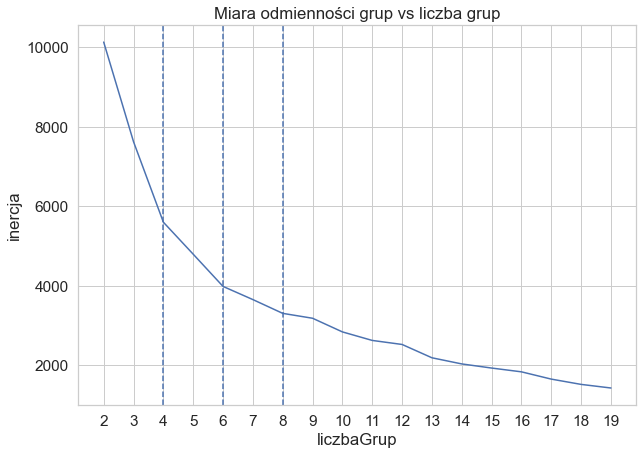

In [117]:
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4, style="whitegrid")
sns.lineplot(data = res, x = 'liczbaGrup', y = 'inercja')
plt.title("Miara odmienności grup vs liczba grup")
plt.axvline(x = 4, linestyle = '--')
plt.axvline(x = 6, linestyle = '--')
plt.axvline(x = 8, linestyle = '--')
plt.xticks(np.arange(2.0, 20, 1.0))
plt.show()

## Model dla czterech klastrów (n=4)

In [124]:
model = KMeans(n_clusters=4)
groups = model.fit_predict(rfm_raw)
rfm['groups'] = groups

### Rozkład liczebności poszczególnych grup

In [126]:
print((rfm.groups.value_counts(normalize = True, sort = True) * 100).to_string())

1   31.614
2   26.851
3   23.115
0   18.420


### Statystyki dla poszczególnych grup

In [127]:
print(rfm.groupby('groups').agg(['mean']))

       Recency Frequency MonetaryValue
          mean      mean          mean
groups                                
0       38.527    35.013       793.591
1      402.928    20.912       354.060
2       23.643   354.199      8138.509
3      242.439   118.158      2344.960


### Interpretacja powstałych grup

**Grupa 0** - klienci, którzy

    * robią zakupy za niewielkie kwoty
    * kupują rzadko
    * niedawno robili zakupy
    
**Grupa 1** - klienci, którzy

    * robią zakupy za niskie kwoty
    * kupują rzadko
    * od bardzo dawna nie robili zakupów
    
**Grupa 2** - klienci, którzy

    * robią zakupy za wysokie kwoty
    * kupują często
    * niedawno robili zakupy
    
**Grupa 3** - klienci, którzy

    * robią zakupy za duże kwoty
    * kupują umiarkowanie często
    * od dawna nie robili zakupów

## Model dla sześciu klastrów (n=6)

In [136]:
model = KMeans(n_clusters=6)
groups = model.fit_predict(rfm_raw)
rfm['groups'] = groups

### Rozkład liczebności poszczególnych grup

In [137]:
print((rfm.groups.value_counts(normalize = True, sort = True) * 100).to_string())

1   22.978
0   21.899
5   15.661
2   13.674
3   13.348
4   12.440


### Statystyki dla poszczególnych grup

In [138]:
print(rfm.groupby('groups').agg(['mean']))

       Recency Frequency MonetaryValue
          mean      mean          mean
groups                                
0      422.950    14.667       236.843
1       25.594   398.560      9222.199
2       35.308    80.129      1715.137
3       39.271    24.764       451.946
4      274.955   156.669      3012.906
5      345.385    44.265       924.481


### Interpretacja powstałych grup

**Grupa 0** - klienci, którzy

    * robią zakupy za bardzo niskie kwoty
    * kupują bardzo rzadko
    * od dawna nie robili zakupów
    
**Grupa 1** - klienci, którzy

    * robią zakupy za bardzo wysokie kwoty
    * kupują bardzo często
    * niedawno robili zakupy
    
**Grupa 2** - klienci, którzy

    * robią zakupy za duże kwoty
    * kupują umiarkowanie często
    * niedawno robili zakupy
    
**Grupa 3** - klienci, którzy

    * robią zakupy za niskie kwoty
    * kupują  rzadko
    * niedawno robili zakupy
    
**Grupa 4** - klienci, którzy

    * robią zakupy za wysokie kwoty
    * kupują często
    * od dłuższego czasu nie robili zakupów
    
**Grupa 5** - klienci, którzy

    * robią zakupy za umiarkowane kwoty
    * kupują umiarkowanie często
    * od długiego czasu nie robili zakupów


## Model dla ośmiu klastrów (n=8)

In [133]:
model = KMeans(n_clusters=8)
groups = model.fit_predict(rfm_raw)
rfm['groups'] = groups

### Rozkład liczebności poszczególnych grup

In [134]:
print((rfm.groups.value_counts(normalize = True, sort = True) * 100).to_string())

3   14.633
5   13.931
6   13.828
4   13.674
7   11.412
1   11.343
0   10.589
2   10.589


### Statystyki dla poszczególnych grup

In [135]:
print(rfm.groupby('groups').agg(['mean']))

       Recency Frequency MonetaryValue
          mean      mean          mean
groups                                
0      185.968    13.366       241.653
1       77.238   285.053      5289.246
2       35.382    28.476       520.874
3      403.622    39.064       583.993
4       35.308    80.129      1715.137
5        9.940   478.845     11940.924
6      280.981   102.230      2136.554
7      530.466    10.479       225.890


### Interpretacja powstałych grup

**Grupa 0** - klienci, którzy

    * robią zakupy za małe kwoty
    * kupują bardzo rzadko
    * od dawna nie robili zakupów
    
**Grupa 1** - klienci, którzy

    * robią zakupy za wysokie kwoty
    * kupują często
    * od dłuższego czasu nie robili zakupów
    
**Grupa 2** - klienci, którzy

    * robią zakupy za umiarkowane kwoty
    * kupują rzadko
    * jakiś czas temu robili zakupy
    
**Grupa 3** - klienci, którzy

    * robią zakupy za umiarkowane kwoty
    * kupują rzadko
    * od bardzo dawna nie robili zakupów
    
**Grupa 4** - klienci, którzy

    * robią zakupy za niemałe kwoty
    * kupują umiarkowanie często
    * jakiś czas temu robili zakupy
    
**Grupa 5** - klienci, którzy

    * robią zakupy za ogromne pieniądze
    * kupują bardzo często
    * niedawno robili zakupy
    
**Grupa 6** - klienci, którzy

    * robią zakupy za niemałe kwoty
    * kupują dosyć często
    * od dawna nie robili zakupów
    
**Grupa 7** - klienci, którzy

    * robią zakupy za bardzo małe kwoty
    * kupują prawie nigdy
    * od bardzo dawna nie robili zakupów

## Wnioski

Moim zdaniem najlepszym modelem jest ten dla czterech bądź sześciu klastrów, zważywszy na fakt iż za konkretnymi grupami z pewnością będą szły jakieś akcje marketingowe. Podział na 8 grup byłby zbyt zagmatwany i ustalanie tylu akcji mogłoby przysporzyć problemu pracownikom działu marketingowego.

Remigiusz Drobinski